<a href="https://colab.research.google.com/github/tam17aki/xvector_voice_statistics/blob/main/xvector_voice_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ランタイムのタイプを変更 から GPU を選択しておくこと

In [1]:
!pip install hydra-core
!pip install progressbar2
!pip install xvector-jtubespeech
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f99e65e183284d3e5f13f0d7344ab2c596b62371f39e5ac8e9fb2d99918aec4f
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=146aae58de17d0ee6ee6098d73de3490e6e393ca9c3123c634249a3360f010ee
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=f4e97775a36bc128403820f5dc0c6552eeaaeb30f13a9461fab62dfbb13db1b3
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
!pip install -U torch torchaudio

In [3]:
import glob
import os
import subprocess

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra import compose, initialize
from progressbar import progressbar as prg
from torchaudio.compliance import kaldi
from umap import UMAP
from xvector_jtubespeech import XVector

In [4]:
!wget https://raw.githubusercontent.com/tam17aki/xvector_voice_statistics/main/config_gdrive.yaml

--2023-07-20 07:52:38--  https://raw.githubusercontent.com/tam17aki/xvector_voice_statistics/main/config_gdrive.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘config_gdrive.yaml’

config_gdrive.yaml  100%[===================>]     610  --.-KB/s    in 0s      

2023-07-20 07:52:39 (34.2 MB/s) - ‘config_gdrive.yaml’ saved [610/610]



In [5]:
def get_corpus(cfg):
    """Download voice-statistics corpurs."""
    corpus_url = cfg.xvector.corpus_url
    data_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.data_dir)
    os.makedirs(data_dir, exist_ok=True)

    print("Downloading voice statistics corpus ...", end="")
    for actor in cfg.actor:  # "tsuchiya", "fujitou", "uemura"
        for emotion in cfg.emotion:  # "angry", "happy", "normal"
            command = "wget " + "-P " + "/tmp/" + " " + corpus_url
            tar_file = actor + "_" + emotion + ".tar.gz"
            command = command + tar_file
            subprocess.run(
                command, text=True, shell=True, capture_output=True, check=True
            )
            command = "cd " + data_dir + "; " + "tar -xzvf " + "/tmp/" + tar_file
            subprocess.run(
                command, text=True, shell=True, capture_output=True, check=True
            )
    print(" done.")

In [6]:
def get_pretrained_model(cfg):
    """Download pretrained model."""
    repo_url = cfg.xvector.repo_url
    data_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.data_dir)
    os.makedirs(data_dir, exist_ok=True)
    model_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.model_dir)
    os.makedirs(model_dir, exist_ok=True)

    print("Downloading pretrained model ...", end="")

    # download pretrained model from github repo.b rerained
    command = "wget " + "-P " + "/tmp/" + " " + repo_url
    subprocess.run(command, text=True, shell=True, capture_output=True, check=True)
    command = "cd " + "/tmp/" + "; " + "unzip " + "master.zip"
    subprocess.run(command, text=True, shell=True, capture_output=True, check=True)
    command = (
        "cp "
        + os.path.join("/tmp/", cfg.pretrained.repo_name, cfg.pretrained.file_name)
        + " "
        + os.path.join(model_dir, cfg.pretrained.file_name)
    )
    subprocess.run(command, text=True, shell=True, capture_output=True, check=True)

    # clean up
    command = "rm " + "/tmp/master.zip"
    subprocess.run(command, text=True, shell=True, capture_output=True, check=True)
    command = "rm -rf " + os.path.join("/tmp/", cfg.pretrained.repo_name)
    subprocess.run(command, text=True, shell=True, capture_output=True, check=True)
    print(" done.")


In [7]:
def extract_xvector(cfg):  # xvector model  # 16kHz mono
    "Extract XVectors from wave file."

    feat_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.feat_dir)
    os.makedirs(feat_dir, exist_ok=True)
    data_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.data_dir)

    model = XVector(
        os.path.join(
            cfg.xvector.root_dir, cfg.xvector.model_dir, cfg.pretrained.file_name
        )
    )
    for actor in cfg.actor:
        out_dir = os.path.join(feat_dir, actor)
        os.makedirs(out_dir, exist_ok=True)
        for emotion in cfg.emotion:
            data_path = data_dir + actor + "_" + emotion
            wav_list = glob.glob(data_path + f"/{actor}_{emotion}_*.wav")
            for wav_file in prg(
                wav_list, prefix=f"Extract xvectors from {emotion} of {actor}: "
            ):
                wav, _ = librosa.load(wav_file, sr=cfg.feature.sample_rate)
                basename = os.path.basename(wav_file)
                basename, _ = os.path.splitext(basename)
                wav = torch.from_numpy(wav.astype(np.float32)).unsqueeze(0)
                mfcc = kaldi.mfcc(
                    wav,
                    num_ceps=cfg.feature.num_ceps,
                    num_mel_bins=cfg.feature.num_melbins,
                )
                mfcc = mfcc.unsqueeze(0)
                xvector = model.vectorize(mfcc)
                xvector = xvector.to("cpu").detach().numpy().copy()[0]
                out_path = os.path.join(out_dir, f"{basename}.npy")
                np.save(out_path, xvector)

In [8]:
with initialize(version_base=None, config_path="."):
    config = compose(config_name="config_gdrive")

get_corpus(config)
get_pretrained_model(config)
extract_xvector(config)

Extract xvectors from angry of tsuchiya: 100% (100 of 100) || Elapsed Time: 0:00:20 Time:  0:00:20
Extract xvectors from happy of tsuchiya: 100% (100 of 100) || Elapsed Time: 0:00:10 Time:  0:00:10
Extract xvectors from normal of tsuchiya: 100% (100 of 100) || Elapsed Time: 0:00:13 Time:  0:00:13
Extract xvectors from angry of fujitou: 100% (100 of 100) || Elapsed Time: 0:00:19 Time:  0:00:19
Extract xvectors from happy of fujitou: 100% (100 of 100) || Elapsed Time: 0:00:17 Time:  0:00:17
Extract xvectors from normal of fujitou: 100% (100 of 100) || Elapsed Time: 0:00:28 Time:  0:00:28
Extract xvectors from angry of uemura: 100% (100 of 100) || Elapsed Time: 0:00:14 Time:  0:00:14
Extract xvectors from happy of uemura: 100% (100 of 100) || Elapsed Time: 0:00:14 Time:  0:00:14
Extract xvectors from normal of uemura: 100% (100 of 100) || Elapsed Time: 0:00:14 Time:  0:00:14


In [9]:
def plot_umap(cfg):
    """Perform UMAP plot in 2D space."""
    feat_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.feat_dir)
    for actor in cfg.actor:
        feat_list = []
        emotion_type = []
        for emotion in cfg.emotion:
            feats_files = glob.glob(feat_dir + actor + "/" + f"{actor}_{emotion}_*.npy")
            for feats in feats_files:
                xvector = np.load(feats)
                xvector = np.expand_dims(xvector, axis=0)
                feat_list.append(xvector)
                if emotion == "angry":
                    emotion_type.append(0)
                elif emotion == "happy":
                    emotion_type.append(1)
                else:  # normal
                    emotion_type.append(2)

        feat_array = np.concatenate(feat_list)
        mapper = UMAP(n_components=2, learning_rate=0.1)
        fit = mapper.fit(feat_array)
        embedding = fit.transform(feat_array)
        embedding_x = embedding[:, 0]
        embedding_y = embedding[:, 1]
        for n in np.unique(emotion_type):
            if n == 0:  # angry
                plt.scatter(
                    embedding_x[emotion_type == n],
                    embedding_y[emotion_type == n],
                    label="angry",
                    s=10,
                )
            elif n == 1:  # happy
                plt.scatter(
                    embedding_x[emotion_type == n],
                    embedding_y[emotion_type == n],
                    label="happy",
                    s=10,
                )
            else:  # normal
                plt.scatter(
                    embedding_x[emotion_type == n],
                    embedding_y[emotion_type == n],
                    label="normal",
                    s=10,
                )

        plt.grid()
        plt.legend(title=actor)
        plt.tight_layout()
        plt.savefig("UMAP_{}.png".format(actor))
        plt.show()


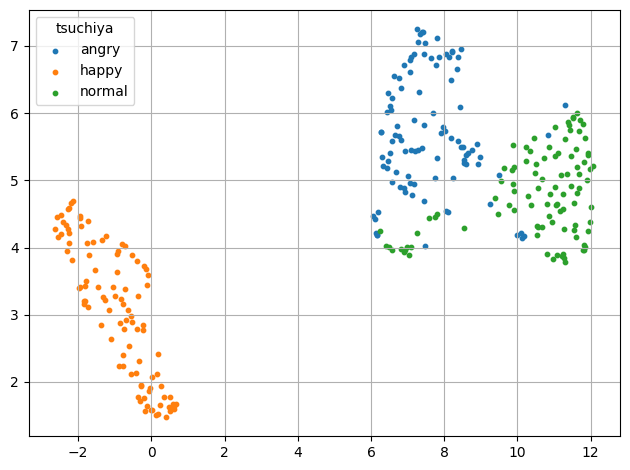

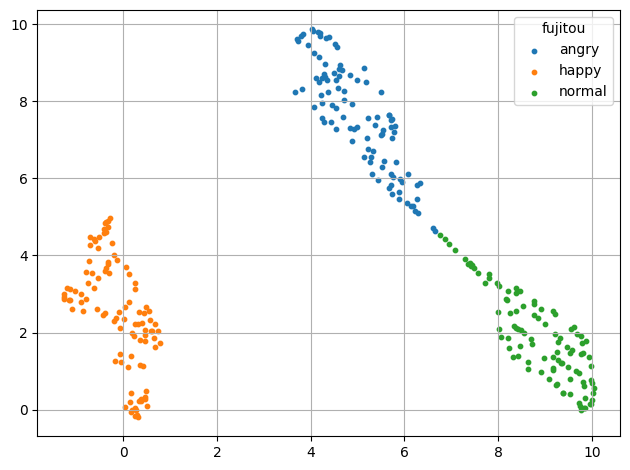

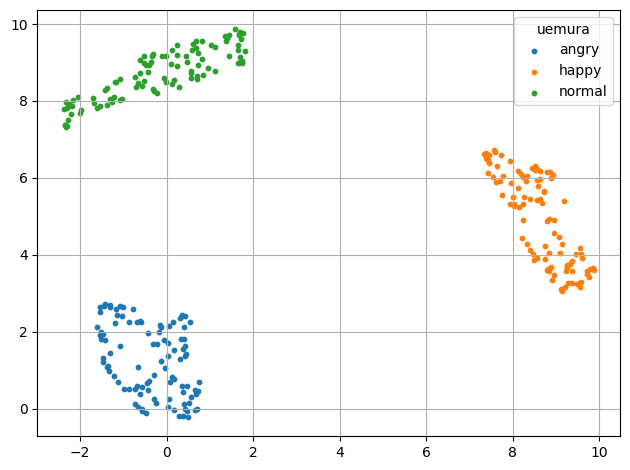

In [10]:
plot_umap(config)

In [11]:
def get_emotion_type(actor, emotion):
    """Return emotion type."""
    emotion_type = -1
    if emotion == "angry" and actor == "tsuchiya":
        emotion_type = 0
    elif emotion == "happy" and actor == "tsuchiya":
        emotion_type = 1
    elif emotion == "normal" and actor == "tsuchiya":
        emotion_type = 2
    elif emotion == "angry" and actor == "fujitou":
        emotion_type = 3
    elif emotion == "happy" and actor == "fujitou":
        emotion_type = 4
    elif emotion == "normal" and actor == "fujitou":
        emotion_type = 5
    elif emotion == "angry" and actor == "uemura":
        emotion_type = 6
    elif emotion == "happy" and actor == "uemura":
        emotion_type = 7
    elif emotion == "normal" and actor == "uemura":
        emotion_type = 8

    return emotion_type


def plot_umap_all(cfg):
    """Perform UMAP plot in 2D space."""
    feat_dir = os.path.join(cfg.xvector.root_dir, cfg.xvector.feat_dir)
    feat_list = []
    emotion_type = []
    for actor in cfg.actor:
        for emotion in cfg.emotion:
            feats_files = glob.glob(feat_dir + actor + "/" + f"{actor}_{emotion}_*.npy")
            for feats in feats_files:
                xvector = np.load(feats)
                xvector = np.expand_dims(xvector, axis=0)
                feat_list.append(xvector)
                emotion_type.append(get_emotion_type(actor, emotion))

    feat_array = np.concatenate(feat_list)
    mapper = UMAP(n_components=2, learning_rate=0.1)
    fit = mapper.fit(feat_array)
    embedding = fit.transform(feat_array)
    embedding_x = embedding[:, 0]
    embedding_y = embedding[:, 1]
    for n in np.unique(emotion_type):
        if n == 0:  # angry tsuchiya
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="tsuchiya-angry",
                s=10,
            )
        elif n == 1:  # happy tsuchiya
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="tsuchiya-happy",
                s=10,
            )
        elif n == 2:  # normal tsuchiya
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="tsuchiya-normal",
                s=10,
            )
        elif n == 3:  # angry fujitou
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="fujitou-angry",
                s=10,
            )
        elif n == 4:  # happy fujitou
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="fujitou-happy",
                s=10,
            )
        elif n == 5:  # normal fujitou
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="fujitou-normal",
                s=10,
            )
        elif n == 6:  # angry uemura
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="uemura-angry",
                s=10,
            )
        elif n == 7:  # happy uemura
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="uemura-happy",
                s=10,
            )
        elif n == 8:  # normal uemura
            plt.scatter(
                embedding_x[emotion_type == n],
                embedding_y[emotion_type == n],
                label="uemura-normal",
                s=10,
            )

    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("UMAP_all.png")
    plt.show()

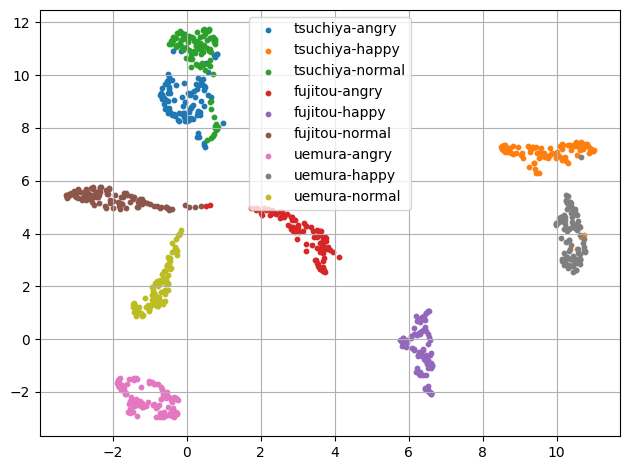

In [12]:
plot_umap_all(config)